In [4]:
import fastai
from fastai.basics import *

In [5]:
mnist = Path("F:/data/fastai/mnist.pkl.gz")
mnist

WindowsPath('F:/data/fastai/mnist.pkl.gz')

In [6]:
with gzip.open(mnist,'rb') as f:
    ((x_train,y_train),(x_valid,y_valid),_) = pickle.load(f,encoding='latin-1')

(50000, 784)

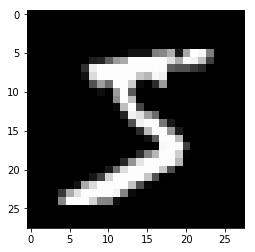

In [7]:
plt.imshow(x_train[0].reshape((28,28)),cmap='gray')
x_train.shape

In [9]:
x_train,y_train,x_valid,y_valid = map(torch.tensor,(x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape,y_train.min(),y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [10]:
train_ds = TensorDataset(x_train,y_train)
valid_ds = TensorDataset(x_valid,y_valid)
data = DataBunch.create(train_ds,valid_ds,bs=64)

### 创建网络

In [11]:
class Mnist_Logisitc(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(28*28,100)
        self.layer2 = nn.Linear(100,10)
    def forward(self,xb):
        out = F.relu(self.layer1(xb))
        return self.layer2(out)
        

In [12]:
model = Mnist_Logisitc().cuda()

In [13]:
model

Mnist_Logisitc(
  (layer1): Linear(in_features=784, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=10, bias=True)
)

In [14]:
model.layer1

Linear(in_features=784, out_features=100, bias=True)

In [15]:
model.layer2

Linear(in_features=100, out_features=10, bias=True)

In [16]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [17]:
model(x).shape

torch.Size([64, 10])

In [19]:
[p.shape for p in model.parameters()]

[torch.Size([100, 784]),
 torch.Size([100]),
 torch.Size([10, 100]),
 torch.Size([10])]

In [20]:
lr = 2e-2

In [21]:
loss_fun = nn.CrossEntropyLoss()

In [27]:
def updata(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    w2 = 0
    for p in model.parameters():
        w2 += (p**2).sum()
    loss = loss_fun(y_hat,y) + wd * w2
    loss.backward()
    
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [28]:
losses = [updata(x,y,lr) for x,y in data.train_dl]

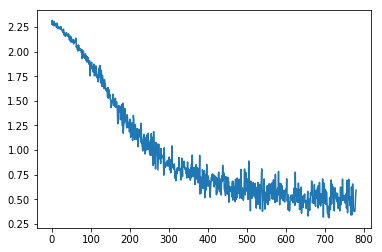

In [29]:
plt.plot(losses)

#### 使用adam优化器

In [46]:
model2 = Mnist_Logisitc().cuda()

In [47]:
def updata_adam(x,y,lr):
    adam = optim.Adam(model2.parameters(),lr = lr)
    y_hat = model2(x)
    loss = loss_fun(y_hat,y)
    loss.backward()
    adam.step()
    adam.zero_grad()
    return loss.item()

In [48]:
losses = [updata_adam(x,y,1e-3) for x,y in data.train_dl]

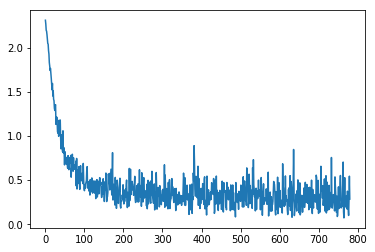

In [49]:
plt.plot(losses)

### 使用fastai的learner

In [50]:
leanner = Learner(data,Mnist_Logisitc(),loss_func = loss_fun,metrics=accuracy)

In [51]:
leanner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


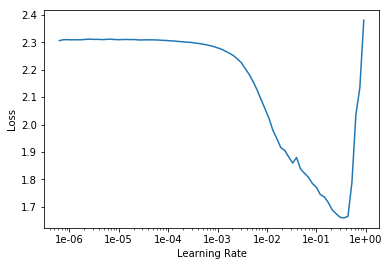

In [53]:
leanner.recorder.plot()

In [54]:
leanner.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.125934,0.108155,0.968200


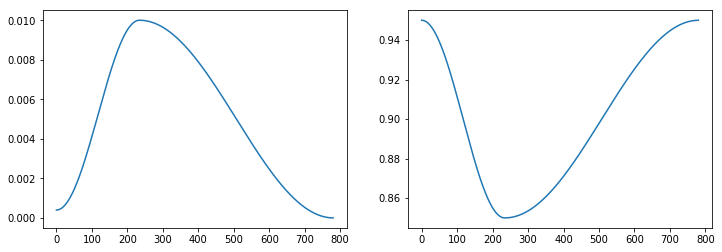

In [55]:
leanner.recorder.plot_lr(show_moms=True)

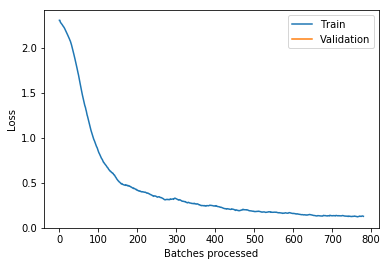

In [56]:
leanner.recorder.plot_losses()